In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_gray(img, title="untitled", **kwargs):
    plt.figure()
    plt.imshow(img, cmap="gray", interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

In [2]:
# parse directory for file names
import os

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

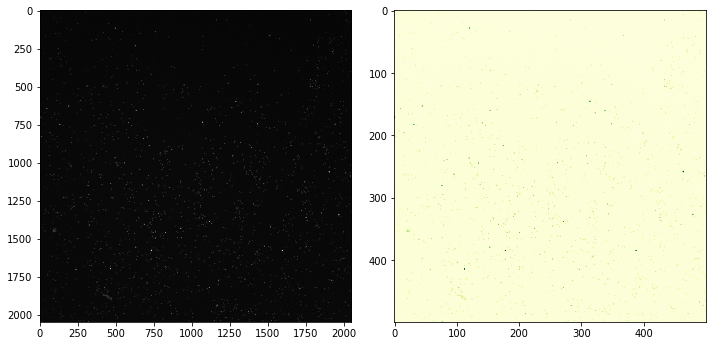

In [39]:
# PLOTTING IMAGES
image_width = 500
image_height = 500

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
file = filenames[0]
image = imread(file)
image_resized = resize(image, (image_width, image_height), anti_aliasing=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(image_resized, cmap='YlGn')
fig.tight_layout()
#new_im = Image.fromarray(image_resized).convert("L")
#new_im.save("/Users/Leonore/Documents/Workspace/l4proj/data/resized/fluorescent_"+str(i)+".jpeg")

In [37]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = imread(file)
        image_resized = resize(image, (image_width, image_height), anti_aliasing=False)
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [38]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

In [39]:
x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

In [40]:
x_train.shape

(471, 200, 200, 1)

In [55]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [57]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 8)         0  

In [58]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 8)         0  

In [59]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [60]:
encoded_imgs = encoder.predict(x_test)

In [61]:
encoder.output.shape[2]*3

Dimension(75)

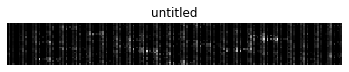

In [62]:
show_gray(np.reshape(encoded_imgs[0],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])))

In [63]:
# input = output because this is image reconstruction
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
471/471 [==============================] - 21s 45ms/step - loss: 0.6925
Epoch 2/50
471/471 [==============================] - 17s 37ms/step - loss: 0.6873
Epoch 3/50
471/471 [==============================] - 17s 35ms/step - loss: 0.6799
Epoch 4/50
471/471 [==============================] - 17s 36ms/step - loss: 0.6704
Epoch 5/50
471/471 [==============================] - 17s 35ms/step - loss: 0.6578
Epoch 6/50
471/471 [==============================] - 17s 35ms/step - loss: 0.6401
Epoch 7/50
471/471 [==============================] - 17s 36ms/step - loss: 0.6145
Epoch 8/50
471/471 [==============================] - 17s 36ms/step - loss: 0.5766
Epoch 9/50
471/471 [==============================] - 17s 35ms/step - loss: 0.5206
Epoch 10/50
471/471 [==============================] - 16s 35ms/step - loss: 0.4409
Epoch 11/50
471/471 [==============================] - 17s 35ms/step - loss: 0.3393
Epoch 12/50
471/471 [==============================] - 17s 36ms/step - loss: 0.2332
E

In [64]:
decoded_imgs = autoencoder.predict(x_test)

array([[0.1637873 , 0.07636908, 0.06197315, ..., 0.066773  , 0.08606926,
        0.19696534],
       [0.07625476, 0.01834917, 0.01247147, ..., 0.01353079, 0.02058864,
        0.08927357],
       [0.06384265, 0.01346359, 0.00862509, ..., 0.00958696, 0.01510131,
        0.07691258],
       ...,
       [0.07524243, 0.01709375, 0.01116326, ..., 0.01208866, 0.0177471 ,
        0.08577567],
       [0.10399607, 0.0281691 , 0.01929829, ..., 0.01934487, 0.02660137,
        0.10201821],
       [0.22470585, 0.12228349, 0.10409132, ..., 0.10686457, 0.12169659,
        0.24905816]], dtype=float32)

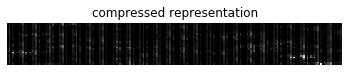

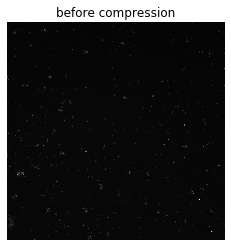

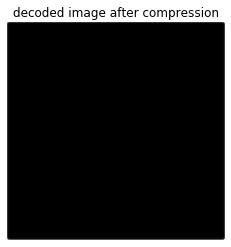

In [71]:
d1 = np.reshape(decoded_imgs[2], (image_width, image_height))
show_gray(np.reshape(encoded_imgs[2],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])), "compressed representation")
e1 = np.reshape(x_test[2], (image_width, image_height))
show_gray(e1, 'before compression')
show_gray(d1, 'decoded image after compression')
d1
#img
#plt.imshow(d1, cmap='coolwarm')